In [28]:
import pandas as pd
import numpy as np
from transformers import pipeline

In [29]:
#Loading the cleaned reviews dataset
def load_data(file_path):
    """
    Load data from a CSV file and return a DataFrame.
    
    Parameters:
    file_path (str): The path to the CSV file.
    
    Returns:
    pd.DataFrame: The loaded data as a DataFrame.
    """
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
data=load_data("../data/processed/cleaned_reviews.csv")
data.head()

,review_text,rating,date,bank_name,source
0,I like this mobile banking app very much. Over...,2,2025-06-07,Dashen Bank,Google Play
1,love,3,2025-06-06,Dashen Bank,Google Play
2,መቸሸጠ,5,2025-06-03,Dashen Bank,Google Play
3,wow,5,2025-06-03,Dashen Bank,Google Play
4,gadaa,5,2025-06-01,Dashen Bank,Google Play


In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# classification of sentiment using VADER
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['review_text'].apply(get_sentiment_score)


In [31]:
data

,review_text,rating,date,bank_name,source,sentiment
0,I like this mobile banking app very much. Over...,2,2025-06-07,Dashen Bank,Google Play,positive
1,love,3,2025-06-06,Dashen Bank,Google Play,positive
2,መቸሸጠ,5,2025-06-03,Dashen Bank,Google Play,neutral
3,wow,5,2025-06-03,Dashen Bank,Google Play,positive
4,gadaa,5,2025-06-01,Dashen Bank,Google Play,neutral
...,...,...,...,...,...,...
1174,why did the screen shot stopped ?????,3,2025-03-24,Commercial Bank of Ethiopia,Google Play,negative
1175,it's genuine app..,5,2025-03-24,Commercial Bank of Ethiopia,Google Play,neutral
1176,okay 👌👍,5,2025-03-24,Commercial Bank of Ethiopia,Google Play,positive
1177,it's a very good application but sometimes it ...,4,2025-03-23,Commercial Bank of Ethiopia,Google Play,positive


### Thematic Analysis (Keyword Extraction + Grouping)
#### TF-Idata

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(data['review_text'])


In [25]:
data.head

<bound method NDFrame.head of                                             review_text  rating        date  \
0     I like this mobile banking app very much. Over...       2  2025-06-07   
1                                                  love       3  2025-06-06   
2                                                  መቸሸጠ       5  2025-06-03   
3                                                   wow       5  2025-06-03   
4                                                 gadaa       5  2025-06-01   
...                                                 ...     ...         ...   
1174              why did the screen shot stopped ?????       3  2025-03-24   
1175                                 it's genuine app..       5  2025-03-24   
1176                                            okay 👌👍       5  2025-03-24   
1177  it's a very good application but sometimes it ...       4  2025-03-23   
1178                                 commercial dank...       5  2025-03-23   

                     

### Sentimental Analysis

In [21]:
import torch
# Load dataset
data = pd.read_csv('../data/processed/cleaned_reviews.csv')

# Load model
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Predict
def predict_sentiment(text):
    result = classifier(text[:512])[0]  # Truncate long reviews
    return result['label'], result['score']

data[['sentiment_label', 'sentiment_score']] = data['review_text'].apply(lambda x: pd.Series(predict_sentiment(x)))
data.to_csv('../data/processed/sentiment_results.csv', index=False)


Device set to use cpu


In [12]:
sentment_data=pd.read_csv('../data/processed/sentiment_results.csv')
sentment_data.head()

,review_text,rating,date,bank_name,source,sentiment_label,sentiment_score
0,I like this mobile banking app very much. Over...,2,2025-06-07,Dashen Bank,Google Play,NEGATIVE,0.990445
1,love,3,2025-06-06,Dashen Bank,Google Play,POSITIVE,0.999874
2,መቸሸጠ,5,2025-06-03,Dashen Bank,Google Play,NEGATIVE,0.697057
3,wow,5,2025-06-03,Dashen Bank,Google Play,POSITIVE,0.999592
4,gadaa,5,2025-06-01,Dashen Bank,Google Play,NEGATIVE,0.721146


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

nlp = spacy.load("en_core_web_sm")
data = pd.read_csv('../data/processed/sentiment_results.csv')

# Basic preprocessing
def clean_text(text):
    doc = nlp(text.lower())
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

data['cleaned_review'] = data['review_text'].apply(clean_text)

# Extract keywords per bank
themes = {}
for bank in data['bank_name'].unique():
    bank_reviews = data[data['bank_name'] == bank]['cleaned_review']
    tfidata = TfidfVectorizer(max_features=20, ngram_range=(1,2))
    X = tfidata.fit_transform(bank_reviews)
    keywords = tfidata.get_feature_names_out()
    themes[bank] = keywords.tolist()

pd.DataFrame.from_dict(themes, orient='index').T.to_csv("../data/keywords_per_bank.csv", index=False)


In [16]:
Data_keywords = pd.read_csv("../data/keywords_per_bank.csv")
Data_keywords.head()

,Dashen Bank,Bank of Abyssinia,Commercial Bank of Ethiopia
0,amazing,app,app
1,app,bad,application
2,application,bank,bank
3,bank,banking,banking
4,banking,boa,cbe


In [33]:

# Ensure sentiment_label is standardized (e.g. upper case)
data['sentiment'] = data['sentiment'].str.upper()

# Group by bank_name and sentiment_label
grouped = data.groupby(['bank_name', 'sentiment']).size().reset_index(name='count')

# Calculate total reviews per bank
total_per_bank = data.groupby('bank_name').size().reset_index(name='total')

# Merge total back to the grouped data
merged = grouped.merge(total_per_bank, on='bank_name')

# Calculate percentage
merged['percentage'] = (merged['count'] / merged['total']) * 100

# Optional: Pivot for a cleaner tabular view
pivot_df = merged.pivot_table(index='bank_name', columns='sentiment', values=['count', 'percentage'], fill_value=0)

# Display
print(pivot_df)


                               count                  percentage             \
sentiment                   NEGATIVE NEUTRAL POSITIVE   NEGATIVE    NEUTRAL   
bank_name                                                                     
Bank of Abyssinia              116.0   155.0    141.0  28.155340  37.621359   
Commercial Bank of Ethiopia     36.0   112.0    211.0  10.027855  31.197772   
Dashen Bank                     26.0    88.0    294.0   6.372549  21.568627   

                                        
sentiment                     POSITIVE  
bank_name                               
Bank of Abyssinia            34.223301  
Commercial Bank of Ethiopia  58.774373  
Dashen Bank                  72.058824  


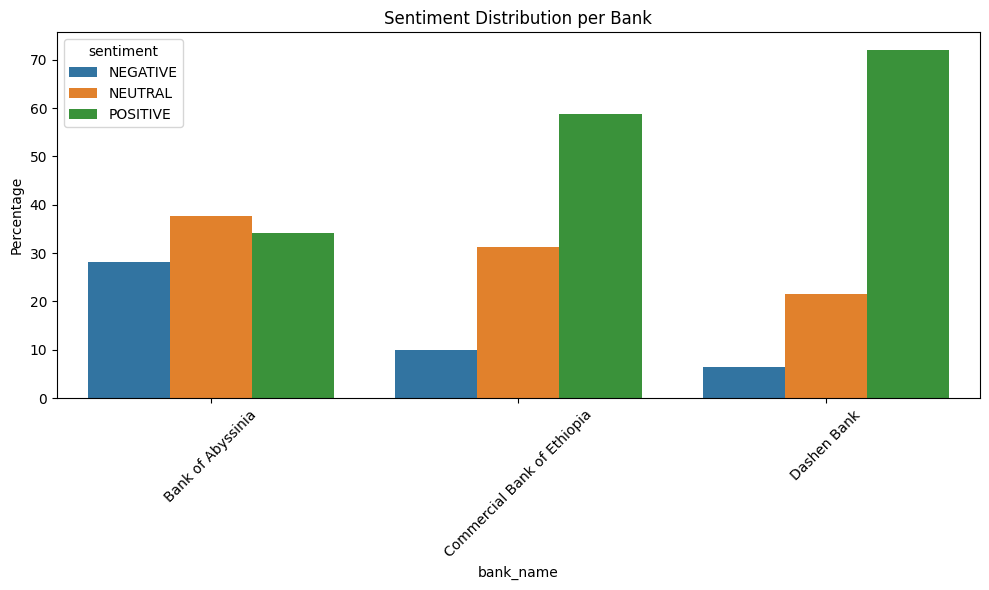

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=merged, x='bank_name', y='percentage', hue='sentiment')
plt.title("Sentiment Distribution per Bank")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
